# Object shape model - estimation

Measure ray features and estimate the model over whole dataset.
We play a bit with different mixture strategies sich as GMM, Mean shift, Kmeans, etc.

In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pylab as plt
from scipy import ndimage

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import imsegm.utilities.data_io as tl_io
import imsegm.region_growing as tl_rg
import imsegm.descriptors as tl_fts

## Loading ovary

In [4]:
COLORS = 'bgrmyck'
PATH_IMAGES = tl_io.update_path(os.path.join('data-images', 'drosophila_ovary_slice'))
PATH_DATA = tl_io.update_path('data-images', absolute=True)
PATH_OUT = tl_io.update_path('output', absolute=True)
PATH_MEASURED_RAYS = os.path.join(PATH_IMAGES, 'eggs_ray-shapes.csv')
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])
dir_annot = os.path.join(PATH_IMAGES, 'annot_eggs')
# dir_annot = os.path.expanduser('/home/jirka/Dropbox/temp/mask_2d_slice_complete_ind_egg')

['center_levels', 'image', 'annot_struct', 'ellipse_fitting', 'annot_eggs', 'segm_rgb', 'segm', 'image_cut-stage-2']


### Loading...

In [5]:
list_paths = sorted(glob.glob(os.path.join(dir_annot, '*.png')))
print ('nb images: %i SAMPLES: \n %s' % (len(list_paths), repr([os.path.basename(p) for p in list_paths[:5]])))
list_segms = []
for path_seg in list_paths:
    seg = np.array(Image.open(path_seg))
    list_segms.append(seg)

nb images: 67 SAMPLES: 
 ['insitu14807.png', 'insitu14808.png', 'insitu14809.png', 'insitu14810.png', 'insitu14811.png']


Randomly selected sample image from fiven dataset.

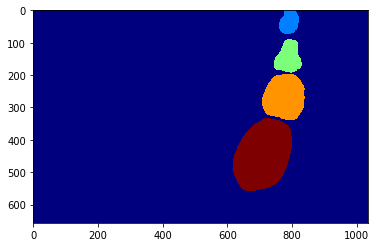

In [6]:
seg = list_segms[np.random.randint(0, len(list_segms))]
_= plt.imshow(seg, cmap=plt.cm.jet)

## Compute Ray features

Simple statistic over measured normalised Ray features over whole dataset.

In [7]:
list_rays, list_shifts = tl_rg.compute_object_shapes(list_segms, ray_step=10, interp_order='spline', smooth_coef=1, shift_method='max')
print ('nb eggs: %i ; nb rays: %i' % (len(list_rays), len(list_rays[0])))

nb eggs: 241 ; nb rays: 36


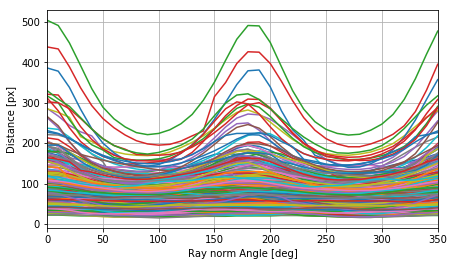

In [9]:
fig = plt.figure(figsize=(7, 4))
x_axis = np.linspace(0, 360, len(list_rays[0]), endpoint=False)
plt.plot(x_axis, np.array(list_rays).T, '-')
plt.grid(), plt.xlim([0, 350])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')
#fig.savefig(os.path.join(PATH_OUT, 'shape-rays_all.pdf'), bbox_inches='tight')

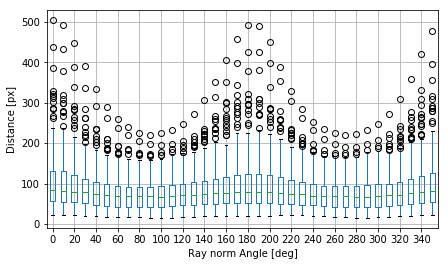

In [10]:
df = pd.DataFrame(np.array(list_rays), columns=x_axis.astype(int))
df.to_csv(PATH_MEASURED_RAYS)

df.plot.box(figsize=(7, 4), grid=True)
plt.plt.xticks(range(1, 37, 2), [str(i * 10) for i in range(0, 36, 2)])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')
#plt.savefig(os.path.join(PATH_OUT, 'shape-rays_statistic.pdf'), bbox_inches='tight')

## Clustering

You can compte thre Ray features from segmentation or load precomputed vectors in CSV file.

In [11]:
df = pd.read_csv(PATH_MEASURED_RAYS, index_col=0)
list_rays = df.values
x_axis = np.linspace(0, 360, list_rays.shape[1], endpoint=False)

### Spectral Clustering

In [12]:
from sklearn import cluster

model = cluster.SpectralClustering(10)
model.fit(np.array(list_rays))
print ('label histogram: %s' % repr(np.bincount(model.labels_)))

list_ray_core = []
for lb in np.unique(model.labels_):
    mean_rays = np.mean(np.asarray(list_rays)[model.labels_ == lb], axis=0)
    mean_rays = ndimage.filters.gaussian_filter1d(mean_rays, 1)
    list_ray_core.append(mean_rays)

label histogram: array([  6,   2,   2,   2,   2,   2,   2,   2,   2, 219])


/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


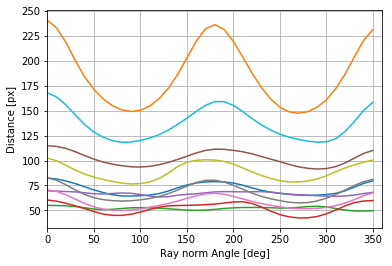

In [18]:
#fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, np.array(list_ray_core).T, '-')
plt.grid(), plt.xlim([0, 360])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Mean Shift

In [19]:
from sklearn import cluster

mean_shift = cluster.MeanShift()
mean_shift.fit(np.array(list_rays))
print ('label histogram: %s' % repr(np.bincount(mean_shift.labels_)))

[8 6 3 2]


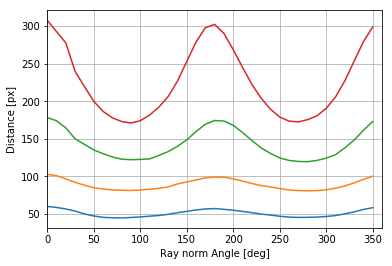

In [20]:
#fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, mean_shift.cluster_centers_.T, '-')
plt.grid(), plt.xlim([0, 360])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Gaussian Mixture Model

In [21]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=10)
gmm.fit(np.array(list_rays))
# gmm.fit(np.array(list_rays), mean_shift_labels)
print ('weights:', gmm.weights_, 'means:', gmm.means_.shape, 'covariances:', gmm.covariances_.shape)

weights: [0.19914697 0.09375047 0.1318912  0.16338295 0.11149782 0.16540886
 0.0531903  0.04021706 0.02724381 0.01427057] means: (10, 36) covariances: (10, 36, 36)


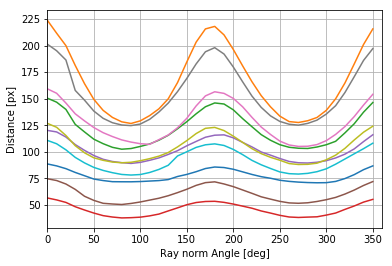

In [22]:
#fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, gmm.means_.T, '-', label=' ')
plt.grid(), plt.xlim([0, 360])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

### Agglomerative Clustering

In [23]:
agg = cluster.AgglomerativeClustering(7)
agg.fit(np.array(list_rays))
# gmm.fit(np.array(list_rays), mean_shift_labels)
print ('label histogram: %s' % repr(np.bincount(agg.labels_)))

list_ray_core = []
for lb in np.unique(model.labels_):
    mean_rays = np.mean(np.asarray(list_rays)[model.labels_ == lb], axis=0)
    mean_rays = ndimage.filters.gaussian_filter1d(mean_rays, 1)
    list_ray_core.append(mean_rays)

[2 4 4 2 3 3 1]


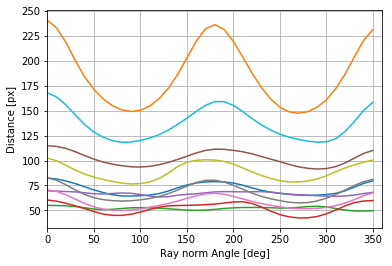

In [24]:
#plt.figure(figsize=(10, 5))
plt.plot(x_axis, np.array(list_ray_core).T, '-')
plt.grid(), plt.xlim([0, 360])
_= plt.xlabel('Ray norm Angle [deg]'), plt.ylabel('Distance [px]')

## Cumulativ Priors

In [13]:
df = pd.read_csv(PATH_MEASURED_RAYS, index_col=0)
list_rays = df.values

In [14]:
def compute_prior_map(cdist, size=(500, 800), step=5):
    prior_map = np.zeros(size)
    centre = np.array(size) / 2
    for i in np.arange(prior_map.shape[0], step=step):
        for j in np.arange(prior_map.shape[1], step=step):
            prior_map[i:i+step, j:j+step] = \
                tl_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=0)
    return prior_map

### Histogram

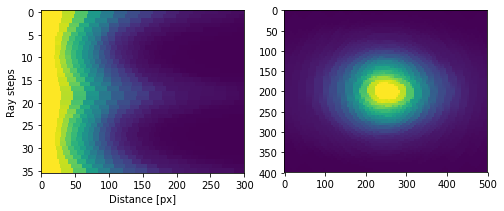

In [15]:
list_cdf = tl_rg.transform_rays_model_cdf_histograms(list_rays, nb_bins=25)
cdist = np.array(list_cdf)

fig = plt.figure(figsize=(8, 3))
_= plt.subplot(1, 2, 1), plt.imshow(cdist[:, :300], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 500), step=5))

### Mixture model

[ 0.21486968  0.05343626  0.17167657  0.13797019  0.01205806  0.1950365
  0.21495274]


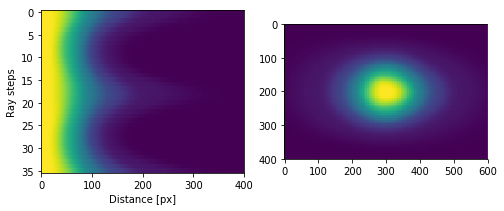

In [16]:
mm, list_cdf = tl_rg.transform_rays_model_cdf_mixture(list_rays, coef_components=1)
cdist = np.array(list_cdf)
print (mm.weights_)

fig = plt.figure(figsize=(8, 3))
_= plt.subplot(1, 2, 1), plt.imshow(cdist[:, :], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 600), step=5))
# plt.savefig('shape-rays_gmm-cdf-proj.pdf')

### Spectral Clustering

label histogram: array([233,   2,   2,   2,   2])


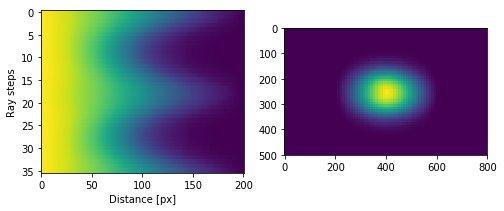

In [17]:
sc, list_cdf = tl_rg.transform_rays_model_cdf_spectral(list_rays)
cdist = np.array(list_cdf)
print ('label histogram: %s' % repr(np.bincount(sc.labels_)))

fig = plt.figure(figsize=(8, 3))
_= plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))

### K-means

label histogram: array([28,  5, 30, 12,  1, 32, 33,  7, 34,  7,  1, 19,  1,  1, 30])


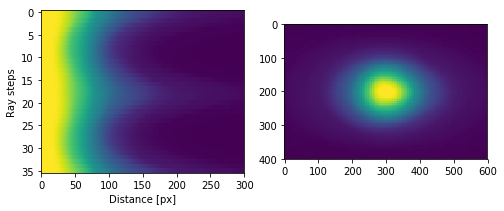

In [18]:
km, list_cdf = tl_rg.transform_rays_model_cdf_kmeans(list_rays, 15)
cdist = np.array(list_cdf)
print ('label histogram: %s' % repr(np.bincount(km.labels_)))

fig = plt.figure(figsize=(8, 3))
_= plt.subplot(1, 2, 1), plt.imshow(cdist[:, :300], aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, size=(400, 600), step=5))

## Mixture of Cumulativ Models

In [19]:
df = pd.read_csv(PATH_MEASURED_RAYS, index_col=0)
list_rays = df.values

### Gaussian mixture

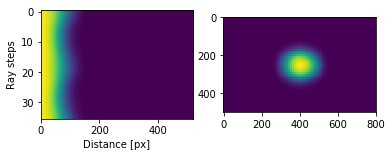

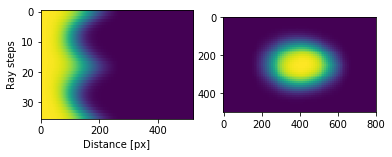

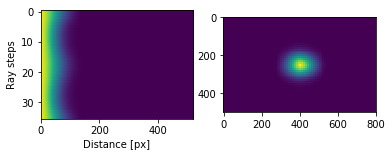

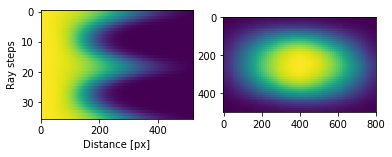

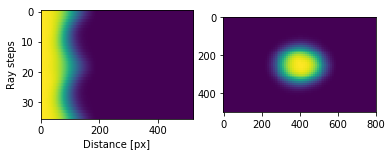

In [20]:
model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_mixture(list_rays, 5)
max_len = max([np.asarray(l_cdf).shape[1] for _, l_cdf in list_mean_cdf])

for i, (mean, list_cdf) in enumerate(list_mean_cdf):
    cdist = np.zeros((len(list_cdf), max_len))
    cdist[:, :len(list_cdf[0])] = np.array(list_cdf)
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.xlim([0, max_len]), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
    plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))
    # plt.savefig('shape-rays_gmm-cdf-proj_%i.pdf' % (i + 1))

### K-Means

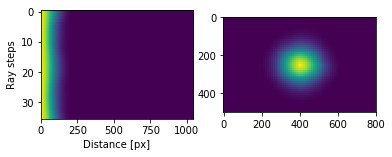

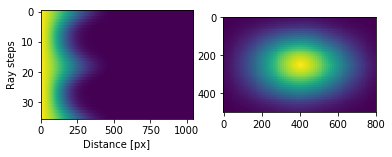

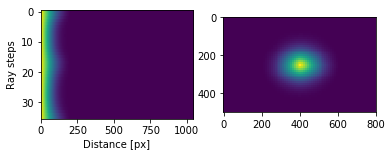

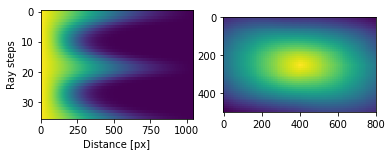

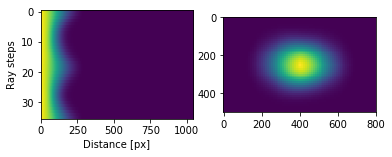

In [21]:
model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_kmeans(list_rays, 5)
max_len = max([np.asarray(l_cdf).shape[1] for _, l_cdf in list_mean_cdf])

for mean, list_cdf in list_mean_cdf:
    cdist = np.zeros((len(list_cdf), max_len))
    cdist[:, :len(list_cdf[0])] = np.array(list_cdf)
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1), plt.imshow(cdist, aspect='auto'), plt.xlim([0, max_len]), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
    plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdist, step=10))

## Show Shape prior with sample egg

In [43]:
seg_object = (seg == 3)
centre = ndimage.measurements.center_of_mass(seg_object)
ray = tl_fts.compute_ray_features_segm_2d(seg_object, centre, edge='down')
_, shift = tl_fts.shift_ray_features(ray)
print ('centre: %s' % repr(centre))
print ('angle shift: %f' % shift)

centre: (426.3299148683429, 224.6435953276579)
angle shift: 220.0


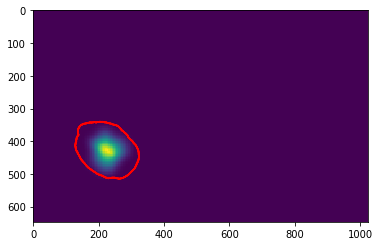

In [44]:
prior_map = np.zeros(seg_object.shape)
error_pos = []
for i in np.arange(prior_map.shape[0], step=5):
    for j in np.arange(prior_map.shape[1], step=5):
        prior_map[i:i+5, j:j+5] = tl_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=shift)

_= plt.imshow(prior_map), plt.contour(seg_object, colors='r')